In [1]:
!pip install  git+https://github.com/tensorflow/docs  tensorflow-probability imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-bmfr43ug
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-bmfr43ug
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184182 sha256=22d14d582418724242792a3ae4d014375199bbaeb4215f53d9c4ecf4de1ec996
  Stored in directory: /tmp/pip-ephem-wheel-cache-zkpc102l/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [2]:
#Loading the Fashion MNIST dataset
from tensorflow.keras.datasets import fashion_mnist
from IPython import display
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

# **Loading the Fashion MNIST Dataset**

To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels. Model each pixel with a Bernoulli distribution in our model, and statically binarize the dataset.

In [3]:
(train_images, _), (test_images, _) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [4]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [5]:
train_size = 60000
batch_size = 32
test_size = 10000

# **Data Batching and Shuffling**

We are tf.data to batch and shuffle the data. The batch combines all the consecutive elements of the dataset into batches. The batch size is the number of samples processed before the model is updated. The number of epochs is the number of complete passes through the training dataset. 

In [6]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

# **Defining an Encoder and Decoder network with Keras Sequential Model**

In this step we use two small ConvNets for the encoding and decoding networks. These networks are also referred to as inference/recognition and generative models. 

We use Sequential models to simplify implementation.  

For an encoder network,  we use two convolutional layers followed by a fully-connected layer.

In the decoder network, we mirror the architecture by using a fully-connected layer followed by three convolution transpose layers. 

In [7]:
#NETWORK ARCHITECTURE
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )
    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )
  @tf.function
  def sample(self, eps=None):
    if eps is None:
        eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)
  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar
  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean
  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
        probs = tf.sigmoid(logits)
        return probs
    return logits

# **Model Optimization**

VAEs train by maximizing the evidence lower bound(ELBO) on the marginal log-likelihood.

In [8]:
optimizer = tf.keras.optimizers.Adam(1e-4)
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)
@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.
  This function computes the loss and gradients and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# **Training the Model and Image Generation**

Now we start the iteration of the dataset. During each iteration, pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximation. After passing the image to the encoder, apply the reparameterization trick to sample from. Finally, pass the reparameterized samples to the decoder to obtain the logits of the generative distribution 

In [9]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

After training the dataset, we can potentially generate the images. Start by sampling a set of latent vectors from the unit Gaussian prior distribution. The generator will then convert the latent sample to logits of the observation, giving a distribution. Here, plot the probabilities of Bernoulli distributions

Epoch: 10, Test set ELBO: -192.93788146972656, time elapse for current epoch: 78.51557159423828


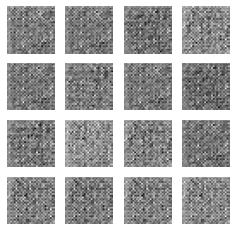

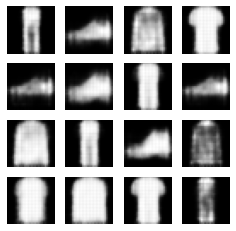

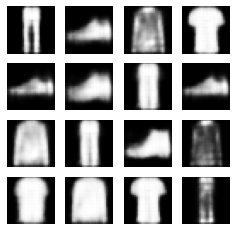

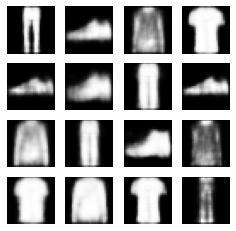

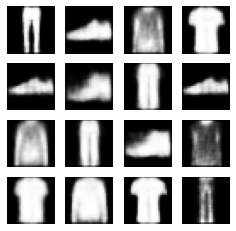

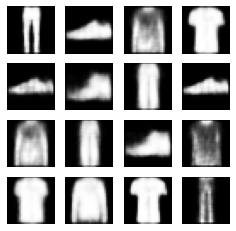

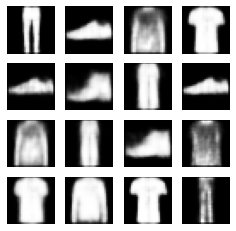

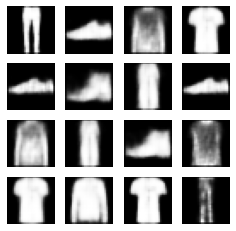

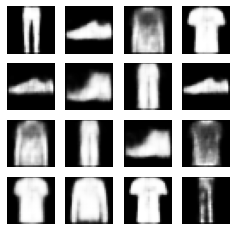

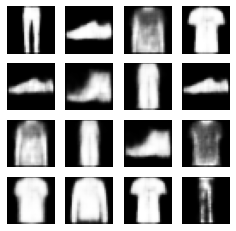

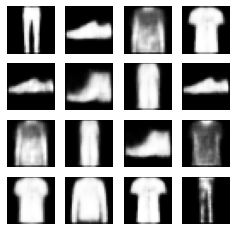

In [10]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))
  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]
#Generating encoded images
generate_and_save_images(model, 0, test_sample)
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()
  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

# **Displaying a 2D manifold of the Fashion_MNIST Dataset**

Now we are visualizing the continuous distribution of the different fashion classes, with each fashion image morphing into another across the 2D latent space.

We use TensorFlow probability to generate a standard normal distribution for the latent space.

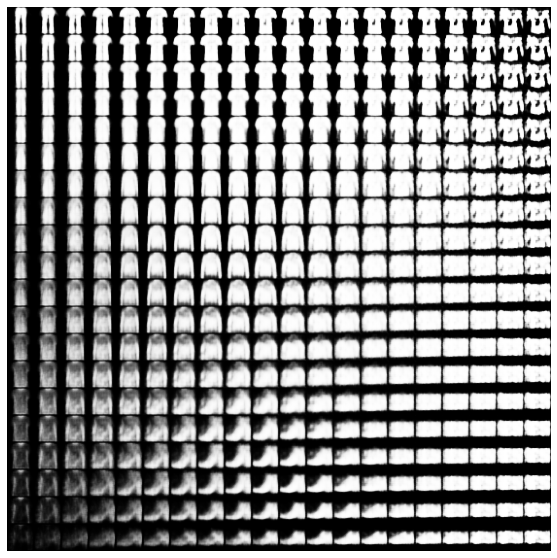

In [11]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""
  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))
  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()
  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()
#Plotting the a latent image 
plot_latent_images(model, 20)